# Parameter Fields

In [55]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.patches import Rectangle, FancyArrowPatch, Patch
from scipy.spatial import Voronoi
from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator, griddata
import scipy.sparse as sp
import scipy.sparse.linalg as spla

EPS = 1e-12

# --- colormaps ---
try:
    import cmcrameri.cm as cmc
    CMAP_K = cmc.batlow
    CMAP_SS = cmc.oslo
    CMAP_FLOW = cmc.lajolla
except Exception:
    CMAP_K = plt.get_cmap("viridis")
    CMAP_SS = plt.get_cmap("cividis")
    CMAP_FLOW = plt.get_cmap("magma")

# --- geometry helpers ---
def generate_pcc_mesh_ghost(Lx, Ly, n_cells, seed=42):
    rng = np.random.default_rng(seed)
    pts = rng.random((n_cells, 2))
    pts[:, 0] *= Lx
    pts[:, 1] *= Ly

    ghosts = [
        np.column_stack((-pts[:, 0], pts[:, 1])),            # Left
        np.column_stack((2*Lx - pts[:, 0], pts[:, 1])),      # Right
        np.column_stack((pts[:, 0], -pts[:, 1])),            # Bottom
        np.column_stack((pts[:, 0], 2*Ly - pts[:, 1])),      # Top
    ]
    all_pts = np.vstack([pts] + ghosts)
    vor = Voronoi(all_pts)
    return vor, pts, all_pts

def voronoi_polygons(vor, n_internal):
    polys = []
    idx = []
    for i in range(n_internal):
        rid = vor.point_region[i]
        reg = vor.regions[rid]
        if -1 in reg or len(reg) == 0:
            continue
        verts = vor.vertices[reg]
        # sort vertices by angle for a clean polygon
        c = verts.mean(axis=0)
        ang = np.arctan2(verts[:,1]-c[1], verts[:,0]-c[0])
        verts = verts[np.argsort(ang)]
        polys.append(verts)
        idx.append(i)
    return polys, np.array(idx, dtype=int)

def voronoi_segments(vor, n_internal):
    segs = []
    for (p1,p2),(v1,v2) in zip(vor.ridge_points, vor.ridge_vertices):
        if v1 < 0 or v2 < 0:
            continue
        if (p1 < n_internal) or (p2 < n_internal):
            segs.append([vor.vertices[v1], vor.vertices[v2]])
    return segs

def build_faces(vor, all_pts, n_internal):
    internal, boundary = [], []
    for (p1,p2),(v1,v2) in zip(vor.ridge_points, vor.ridge_vertices):
        if v1 < 0 or v2 < 0:
            continue
        dist = np.linalg.norm(all_pts[p1] - all_pts[p2])
        if dist < 1e-12:
            continue
        face_len = np.linalg.norm(vor.vertices[v1] - vor.vertices[v2])

        in1, in2 = p1 < n_internal, p2 < n_internal
        if in1 and in2:
            internal.append((p1, p2, face_len, dist))
        elif in1 ^ in2:
            p_in = p1 if in1 else p2
            p_out = p2 if in1 else p1
            off = p_out - n_internal
            if off < n_internal:
                bc = "Left"
            elif off < 2*n_internal:
                bc = "Right"
            elif off < 3*n_internal:
                bc = "Bottom"
            else:
                bc = "Top"
            boundary.append((p_in, bc, face_len, dist/2.0))
    return internal, boundary

def solve_steady_head(n, internal, boundary, K_vals):
    # Dirichlet: Left=1, Right=0. Top/Bottom no-flow
    row, col, data = [], [], []
    rhs = np.zeros(n, dtype=float)

    for (i,j,L,D) in internal:
        T = 2*K_vals[i]*K_vals[j]/(K_vals[i]+K_vals[j]+EPS) * (L/(D+EPS))
        row += [i,i,j,j]
        col += [i,j,i,j]
        data += [T, -T, -T, T]

    for (i,bc,L,Db) in boundary:
        if bc in ["Top","Bottom"]:
            continue
        Tb = K_vals[i] * (L/(Db+EPS))
        row.append(i); col.append(i); data.append(Tb)
        if bc == "Left":
            rhs[i] += Tb*1.0

    A = sp.csr_matrix((data, (row, col)), shape=(n, n))
    h = spla.spsolve(A, rhs)
    return h

def compute_velocity(pts, internal, h, K_vals):
    n = len(pts)
    v = np.zeros((n,2), dtype=float)
    for (i,j,L,D) in internal:
        T = 2*K_vals[i]*K_vals[j]/(K_vals[i]+K_vals[j]+EPS) * (L/(D+EPS))
        q = T*(h[i]-h[j])
        u = (pts[j]-pts[i])/(np.linalg.norm(pts[j]-pts[i])+EPS)
        v[i] += q*u
        v[j] -= q*u
    speed = np.linalg.norm(v, axis=1)
    return v, speed

# --- field generators ---
def gen_lnK(nx, ny, dx, rng, model_type, mu_ln=0.0, sigma_ln=2.0, corr_len=20.0):
    z = rng.normal(0,1,(ny,nx))
    f = gaussian_filter(z, sigma=max(1e-6, corr_len/dx), mode="reflect")
    f = (f - f.mean())/(f.std()+EPS)

    if model_type == 0:
        g = f
    elif model_type == 1:
        g = -np.abs(f)
        g = (g - g.mean())/(g.std()+EPS)
    else:
        g = np.where(f > 0.5, 1.0, -1.0)

    return g*sigma_ln + mu_ln

def gen_lnSs_correlated(lnK, nx, ny, dx, rng, mu_lnSs=-6.0, sigma_lnSs=1.0, corr_len_Ss=20.0, rho=0.5):
    Zk = (lnK - lnK.mean())/(lnK.std()+EPS)
    z2 = rng.normal(0,1,(ny,nx))
    z2 = gaussian_filter(z2, sigma=max(1e-6, corr_len_Ss/dx), mode="reflect")
    Z2 = (z2 - z2.mean())/(z2.std()+EPS)
    rho = float(np.clip(rho, -1, 1))
    Zs = rho*Zk + np.sqrt(max(0.0, 1-rho**2))*Z2
    return Zs*sigma_lnSs + mu_lnSs

# =========================
# Scenario definition
# =========================
Lx, Ly = 100.0, 100.0
N_CELLS = 4000
MESH_SEED = 101

# severity sweep
corrK_levels = np.linspace(30.0, 10.0, 6)
corrS_levels = np.linspace(30.0, 10.0, 6)

SIGMA_LEVELS = [
    {"name":"L1", "sigma_lnK":0.6, "sigma_lnSs":0.25, "corr_len_K":12.0, "corr_len_Ss":12.0},
    {"name":"L2", "sigma_lnK":1.0, "sigma_lnSs":0.40, "corr_len_K":10.0, "corr_len_Ss":10.0},
    {"name":"L3", "sigma_lnK":1.6, "sigma_lnSs":0.65, "corr_len_K":8.0, "corr_len_Ss":8.0},
    {"name":"L4", "sigma_lnK":2.3, "sigma_lnSs":0.95, "corr_len_K":6.0, "corr_len_Ss":6.0},
    {"name":"L5", "sigma_lnK":3.1, "sigma_lnSs":1.20, "corr_len_K":4.0, "corr_len_Ss":4.0},
    {"name":"L6", "sigma_lnK":4.0, "sigma_lnSs":1.50, "corr_len_K":2.0, "corr_len_Ss":2.0},
]


CORR_LEN_K = 20.0
CORR_LEN_SS = 20.0
RHO = 0.5

# choose one seed per column for the sigma-sweep figure
FIELD_SEED_BASE = 42

# if you also want a seed-sweep figure later
SEED_SWEEP = [11, 22, 33]   # optional

# grid for generating fields
NXG, NYG = 301, 301
dx = Lx/(NXG-1)
y_g, x_g = np.mgrid[0:Ly:complex(0, NYG), 0:Lx:complex(0, NXG)]
grid_pts = np.column_stack([x_g.ravel(), y_g.ravel()])

# flow grid for streamplot
FLOW_N = 140
xi = np.linspace(0, Lx, FLOW_N)
yi = np.linspace(0, Ly, FLOW_N)
Xi, Yi = np.meshgrid(xi, yi)

# =========================
# Build mesh once
# =========================
vor, pts, all_pts = generate_pcc_mesh_ghost(Lx, Ly, N_CELLS, MESH_SEED)
polys, poly_idx = voronoi_polygons(vor, N_CELLS)
segs = voronoi_segments(vor, N_CELLS)
internal_faces, boundary_faces = build_faces(vor, all_pts, N_CELLS)

# =========================
# Precompute results for sigma sweep
# results[(severity_idx, model_type)] = dict(...)
# =========================
results_sigma = {}
results_flow = {}  # only for Extreme row

for s_i, lev in enumerate(SIGMA_LEVELS):
    for m_type in [0,1,2]:
        rng = np.random.default_rng(FIELD_SEED_BASE + 100*m_type + 10*s_i)

        lnK = gen_lnK(NXG, NYG, dx, rng, m_type,
                     mu_ln=0.0, sigma_ln=lev["sigma_lnK"], corr_len=lev["corr_len_K"])
        lnSs = gen_lnSs_correlated(lnK, NXG, NYG, dx, rng,
                                   mu_lnSs=-6.0, sigma_lnSs=lev["sigma_lnSs"],
                                   corr_len_Ss=lev["corr_len_Ss"], rho=RHO)

        K_grid = np.exp(lnK)
        Ss_grid = np.exp(lnSs)

        interpK = NearestNDInterpolator(grid_pts, K_grid.ravel())
        interpSs = NearestNDInterpolator(grid_pts, Ss_grid.ravel())

        K_pcc = interpK(pts)
        Ss_pcc = interpSs(pts)

        lnK_pcc = np.log(K_pcc + EPS)
        lnSs_pcc = np.log(Ss_pcc + EPS)

        # normalize to show structure comparably across sigma
        lnK_norm = (lnK_pcc - 0.0) / lev["sigma_lnK"]
        lnSs_norm = (lnSs_pcc - (-6.0)) / lev["sigma_lnSs"]

        results_sigma[(s_i, m_type)] = {
            "severity": lev["name"],
            "model_type": m_type,
            "sigma_lnK": lev["sigma_lnK"],
            "sigma_lnSs": lev["sigma_lnSs"],
            "lnK_norm_poly": lnK_norm[poly_idx],
            "lnSs_norm_poly": lnSs_norm[poly_idx],
        }

        # compute flow only for Extreme row by default
        if lev["name"] == "Extreme":
            h = solve_steady_head(len(pts), internal_faces, boundary_faces, K_pcc)
            v, speed = compute_velocity(pts, internal_faces, h, K_pcc)
            log_speed = np.log10(speed + EPS)

            vx_g = griddata(pts, v[:,0], (Xi, Yi), method="linear", fill_value=0.0)
            vy_g = griddata(pts, v[:,1], (Xi, Yi), method="linear", fill_value=0.0)

            results_flow[m_type] = {
                "log_speed_poly": log_speed[poly_idx],
                "h": h,
                "vx_g": vx_g,
                "vy_g": vy_g,
            }

# global color limits
K_CLIM = (-2.2, 2.2)
SS_CLIM = (-2.2, 2.2)

if results_flow:
    all_logv = np.hstack([results_flow[m]["log_speed_poly"] for m in results_flow])
    V_CLIM = np.percentile(all_logv, [2, 98])
else:
    V_CLIM = (-6, 0)


In [56]:
# Cell 1. Compute / prepare (no plotting)

import numpy as np

# Required objects should already exist from your compute pipeline:
# SIGMA_LEVELS, results_sigma, polys, segs, Lx, Ly, K_CLIM, SS_CLIM

required = ["SIGMA_LEVELS", "results_sigma", "polys", "segs", "Lx", "Ly", "K_CLIM", "SS_CLIM"]
missing = [k for k in required if k not in globals()]
if missing:
    raise NameError(f"Missing required variables: {missing}")

MT_LEVELS = [0, 1, 2]
MT_NAME = {0: "Gaussian", 1: "Connectivity", 2: "Boolean"}

# Extract arrays once. So you can re-run the plot cell quickly.
valsK = {}
valsS = {}
for s_i, _ in enumerate(SIGMA_LEVELS):
    for m_type in MT_LEVELS:
        valsK[(s_i, m_type)] = results_sigma[(s_i, m_type)]["lnK_norm_poly"]
        valsS[(s_i, m_type)] = results_sigma[(s_i, m_type)]["lnSs_norm_poly"]

payload = {
    "SIGMA_LEVELS": SIGMA_LEVELS,
    "MT_LEVELS": MT_LEVELS,
    "MT_NAME": MT_NAME,
    "valsK": valsK,
    "valsS": valsS,
    "polys": polys,
    "segs": segs,
    "Lx": Lx,
    "Ly": Ly,
    "K_CLIM": K_CLIM,
    "SS_CLIM": SS_CLIM,
}
print("Prepared payload for plotting.")


Prepared payload for plotting.


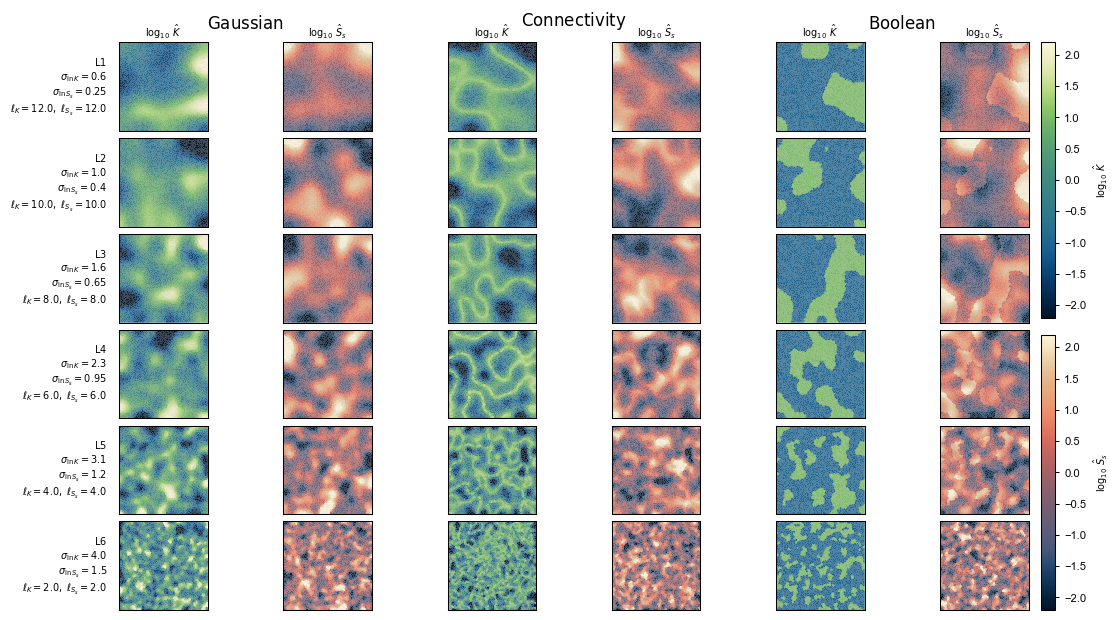

Saved: Figure1_SigmaSweep_K_Ss.png and .pdf


In [59]:
# Cell 2. Plot only. K + Ss only. No letters. Tighter packing. Stacked colorbars.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection

# --- colormaps ---
try:
    import cmcrameri.cm as cmc
    CMAP_K = cmc.navia
    CMAP_SS = cmc.lipari
except Exception:
    CMAP_K = plt.get_cmap("viridis")
    CMAP_SS = plt.get_cmap("cividis")

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "legend.fontsize": 7,
    "mathtext.fontset": "dejavusans",
})

def clean_ax(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")

def _union_bbox(axes_list):
    bbs = [ax.get_position() for ax in axes_list]
    x0 = min(bb.x0 for bb in bbs); y0 = min(bb.y0 for bb in bbs)
    x1 = max(bb.x1 for bb in bbs); y1 = max(bb.y1 for bb in bbs)
    return x0, y0, x1, y1

def plot_sigma_sweep_K_Ss(payload, figsize=(12.0, 6.6), show_edges=True, out="Figure1_SigmaSweep_K_Ss"):
    SIGMA_LEVELS = payload["SIGMA_LEVELS"]
    MT_LEVELS = payload["MT_LEVELS"]
    MT_NAME = payload["MT_NAME"]
    valsK = payload["valsK"]
    valsS = payload["valsS"]
    polys = payload["polys"]
    segs = payload["segs"]
    Lx = payload["Lx"]
    Ly = payload["Ly"]
    K_CLIM = payload["K_CLIM"]
    SS_CLIM = payload["SS_CLIM"]

    n_rows = len(SIGMA_LEVELS)
    fig = plt.figure(figsize=figsize)

    # tighter grid spacing
    gs = fig.add_gridspec(1, 1)
    gsR = gs[0, 0].subgridspec(n_rows, 6, hspace=0.08, wspace=0.008)

    axK_top, axS_top, axK_left = {}, {}, {}
    K_axes, S_axes = [], []
    mK = mSs = None

    for s_i, lev in enumerate(SIGMA_LEVELS):
        for m_type in MT_LEVELS:
            # K
            axK = fig.add_subplot(gsR[s_i, 2 * m_type])
            pcK = PolyCollection(polys, array=valsK[(s_i, m_type)], cmap=CMAP_K,
                                 edgecolors="none", rasterized=True)
            pcK.set_clim(*K_CLIM)
            axK.add_collection(pcK)

            if show_edges:
                axK.add_collection(LineCollection(segs, colors=(0, 0, 0, 0.10), linewidths=0.18))

            axK.set_xlim(0, Lx); axK.set_ylim(0, Ly)
            clean_ax(axK)

            if s_i == 0:
                axK_top[m_type] = axK
            if m_type == 0:
                axK_left[s_i] = axK

            K_axes.append(axK)
            mK = pcK

            # Ss
            axS = fig.add_subplot(gsR[s_i, 2 * m_type + 1])
            pcS = PolyCollection(polys, array=valsS[(s_i, m_type)], cmap=CMAP_SS,
                                 edgecolors="none", rasterized=True)
            pcS.set_clim(*SS_CLIM)
            axS.add_collection(pcS)

            if show_edges:
                axS.add_collection(LineCollection(segs, colors=(0, 0, 0, 0.10), linewidths=0.18))

            axS.set_xlim(0, Lx); axS.set_ylim(0, Ly)
            clean_ax(axS)

            if s_i == 0:
                axS_top[m_type] = axS

            S_axes.append(axS)
            mSs = pcS

    # tighter outer margins. give more room to the grid. keep a narrow strip for colorbars
    fig.subplots_adjust(left=0.12, right=0.94, top=0.92, bottom=0.06)

    # Column headers
    for m_type in MT_LEVELS:
        posK = axK_top[m_type].get_position()
        posS = axS_top[m_type].get_position()
        x_center = 0.5 * (posK.x0 + posS.x1)
        y_top = max(posK.y1, posS.y1)

        fig.text(x_center, y_top + 0.016, rf"$\mathrm{{{MT_NAME[m_type]}}}$",
                 ha="center", va="bottom", fontsize=12, fontweight="bold")

        fig.text(0.5 * (posK.x0 + posK.x1), y_top + 0.003, r"$\log_{10}\,\hat{K}$",
                 ha="center", va="bottom", fontsize=7)
        fig.text(0.5 * (posS.x0 + posS.x1), y_top + 0.003, r"$\log_{10}\,\hat{S}_s$",
                 ha="center", va="bottom", fontsize=7)

    # Row labels. include sigma and corr_len
    for s_i, lev in enumerate(SIGMA_LEVELS):
        pos = axK_left[s_i].get_position()
        y_mid = 0.5 * (pos.y0 + pos.y1)

        clK = lev.get("corr_len_K", None)
        clS = lev.get("corr_len_Ss", None)

        lines = [
            rf"$\mathrm{{{lev['name']}}}$",
            rf"$\sigma_{{\ln K}}={lev['sigma_lnK']}$",
            rf"$\sigma_{{\ln S_s}}={lev['sigma_lnSs']}$",
        ]
        if (clK is not None) and (clS is not None):
            lines.append(rf"$\ell_K={clK},\ \ell_{{S_s}}={clS}$")
        elif clK is not None:
            lines.append(rf"$\ell={clK}$")

        fig.text(pos.x0 - 0.010, y_mid, "\n".join(lines),
                 ha="right", va="center", fontsize=7)

    # Colorbars. stack vertically to avoid overlap
    x0_all, y0_all, x1_all, y1_all = _union_bbox(K_axes + S_axes)
    H = y1_all - y0_all

    cb_w = 0.012
    x_cb = min(0.965, x1_all + 0.010)  # keep inside figure

    gap = 0.03 * H
    cb_h = (H - gap) / 2.0

    caxK = fig.add_axes([x_cb, y0_all + cb_h + gap, cb_w, cb_h])
    caxS = fig.add_axes([x_cb, y0_all,              cb_w, cb_h])

    cb1 = fig.colorbar(mK, cax=caxK)
    cb2 = fig.colorbar(mSs, cax=caxS)
    cb1.set_label(r"$\log_{10}\,\hat{K}$", fontsize=7)
    cb2.set_label(r"$\log_{10}\,\hat{S}_s$", fontsize=7)

    fig.savefig(out + ".png", dpi=600)
    fig.savefig(out + ".pdf")
    plt.show()
    print("Saved:", out + ".png and .pdf")

# Run
plot_sigma_sweep_K_Ss(payload, show_edges=True, out="Figure1_SigmaSweep_K_Ss")


# PCC: Data Generation

In [98]:
import os
import time
import warnings
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter
from scipy.sparse import csc_matrix, diags, linalg
from scipy.spatial import Voronoi
from scipy.stats import qmc

warnings.filterwarnings("ignore")

# ==========================================================
# Settings
# ==========================================================
#OUT_DIR = "freq_only_storage_q"
OUT_DIR = "freq_only_flux_q"

os.makedirs(OUT_DIR, exist_ok=True)

RNG_SEED = 1234
rng_global = np.random.default_rng(RNG_SEED)

Lx = 100.0
Ly = 100.0

nx_grid, ny_grid = 401, 401
dx_grid, dy_grid = Lx / (nx_grid - 1), Ly / (ny_grid - 1)

N_CELLS_PCC = 10000
N_SAMPLES = 10000

USE_FLOAT32_FIELDS = True
FIX_MESH = True
FIXED_MESH_SEED = 2025

FMAX_FACTOR = 0.1  # f_max = 0.1/dt, clipped by Nyquist safety

# ==========================================================
# Frequency-domain multisine experiment definition
# ==========================================================
@dataclass(frozen=True)
class Experiment:
    name: str
    T: float
    dt: float
    hL_mean: float = 6.0
    hL_span: float = 2.0
    hR_const: float = 0.0
    K_pe: int = 25

def _safe_fmax(dt: float, fmax_factor: float = 0.1) -> float:
    f_nyq = 0.5 / dt
    fmax = fmax_factor / dt
    if fmax >= 0.45 * f_nyq:
        fmax = 0.45 * f_nyq
    return float(fmax)

def build_time_grid(T: float, dt: float) -> Tuple[int, np.ndarray]:
    nt = int(T / dt) + 1
    t_all = np.linspace(0.0, T, nt, dtype=np.float64)
    return nt, t_all

def multisine_spec(T: float, dt: float, K_pe: int) -> Tuple[np.ndarray, np.ndarray]:
    f_min = 2.0 / T
    f_max = _safe_fmax(dt, fmax_factor=FMAX_FACTOR)
    freqs = np.logspace(np.log10(f_min), np.log10(f_max), K_pe).astype(np.float64)
    k = np.arange(1, K_pe + 1, dtype=np.float64)
    phases = np.pi * (k - 1.0) * (k - 1.0) / float(K_pe)
    return freqs, phases

def multisine_bc_from_spec(t_all: np.ndarray, mean: float, span: float, freqs: np.ndarray, phases: np.ndarray) -> np.ndarray:
    K_pe = len(freqs)
    amps = (span / np.sqrt(K_pe)) * np.ones_like(freqs)
    tt = t_all[:, None]
    ff = freqs[None, :]
    ph = phases[None, :]
    h = mean + np.sum(amps[None, :] * np.sin(2.0 * np.pi * ff * tt + ph), axis=1)
    return h.astype(np.float64)

def build_bc_pack(exp: Experiment) -> Dict:
    nt, t_all = build_time_grid(exp.T, exp.dt)
    freqs, phases = multisine_spec(exp.T, exp.dt, exp.K_pe)

    h_L_all = multisine_bc_from_spec(t_all, exp.hL_mean, exp.hL_span, freqs, phases)
    h_R_all = np.full_like(h_L_all, float(exp.hR_const), dtype=np.float64)

    grad_template = (h_L_all[1:] - h_R_all[1:]) / float(Lx)
    tone_amp = float(exp.hL_span / np.sqrt(exp.K_pe))

    return {
        "name": exp.name,
        "T": float(exp.T),
        "dt": float(exp.dt),
        "nt": int(nt),
        "t_all": t_all,
        "h_L_all": h_L_all,
        "h_R_all": h_R_all,
        "grad_template": grad_template.astype(np.float32),
        "freqs": freqs,
        "phases": phases,
        "tone_amp": tone_amp,
        "hL_mean": float(exp.hL_mean),
        "hR_const": float(exp.hR_const),
    }

EXPERIMENTS: List[Experiment] = [
    Experiment(name="midband_multisine", T=4000.0, dt=1.0, K_pe=25),
    Experiment(name="lowband_multisine", T=16000.0, dt=1.0, K_pe=25),
]
BC_PACKS: List[Dict] = [build_bc_pack(exp) for exp in EXPERIMENTS]

np.savez(
    os.path.join(OUT_DIR, "bc_info.npz"),
    names=np.array([b["name"] for b in BC_PACKS]),
    T=np.array([b["T"] for b in BC_PACKS]),
    dt=np.array([b["dt"] for b in BC_PACKS]),
    nt=np.array([b["nt"] for b in BC_PACKS]),
    **{f"t_all_{b['name']}": b["t_all"] for b in BC_PACKS},
)

# ==========================================================
# Stratified LHS params
# ==========================================================
def stratified_lhs_params(n_total: int, seed: int, L: float) -> np.ndarray:
    param_bounds = {
        "mu_lnK": [-12.0, -2.0],
        "mu_lnSs": [-10.0, -4.0],
        "sigma_lnK": [0.1, 3.0],
        "corr_len_K": [L * 0.01, L * 0.70],
        "sigma_lnSs": [0.1, 2.0],
        "corr_len_Ss": [L * 0.01, L * 0.70],
        "rho": [-1.0, 1.0],
    }
    names = list(param_bounds.keys())
    d = len(names)
    model_type_floats = [0.1667, 0.5000, 0.8333]

    rng = np.random.default_rng(seed)
    base = n_total // 3
    rem = n_total - 3 * base
    counts = [base, base, base]
    for i in range(rem):
        counts[i] += 1

    l_bounds = np.array([param_bounds[k][0] for k in names], dtype=float)
    u_bounds = np.array([param_bounds[k][1] for k in names], dtype=float)

    blocks = []
    for mt_i, n_i in enumerate(counts):
        sampler = qmc.LatinHypercube(d=d, seed=int(seed + 1000 + mt_i))
        unit = sampler.random(n=n_i)
        block = qmc.scale(unit, l_bounds, u_bounds)
        mt_col = np.full((n_i, 1), model_type_floats[mt_i], dtype=float)
        blocks.append(np.hstack([block, mt_col]))

    params = np.vstack(blocks)
    rng.shuffle(params, axis=0)
    return params

param_samples = stratified_lhs_params(N_SAMPLES, RNG_SEED, float(Lx))
np.save(os.path.join(OUT_DIR, "param_samples.npy"), param_samples)

# ==========================================================
# PCC mesh
# ==========================================================
class RobustPCCMesh:
    def __init__(self, Lx: float, Ly: float, n_cells: int, seed: int):
        self.Lx, self.Ly = float(Lx), float(Ly)
        self.n_cells = int(n_cells)
        self.dx_grid = self.Lx / (nx_grid - 1)
        self.dy_grid = self.Ly / (ny_grid - 1)

        self.rng = np.random.default_rng(int(seed))
        self._generate_bounded_voronoi()
        self._precompute_point_to_grid_indices()

    def _generate_bounded_voronoi(self):
        points = self.rng.random((self.n_cells, 2))
        points[:, 0] *= self.Lx
        points[:, 1] *= self.Ly

        ghosts_list = [
            np.column_stack((-points[:, 0], points[:, 1])),
            np.column_stack((2 * self.Lx - points[:, 0], points[:, 1])),
            np.column_stack((points[:, 0], -points[:, 1])),
            np.column_stack((points[:, 0], 2 * self.Ly - points[:, 1])),
        ]
        all_points = np.vstack([points] + ghosts_list)
        vor = Voronoi(all_points)

        self.n = self.n_cells
        self.points = points.astype(np.float64)
        self.areas = np.zeros(self.n, dtype=np.float64)

        internal_i, internal_j, internal_len, internal_dist = [], [], [], []
        b_i, b_type, b_len, b_dist = [], [], [], []

        for i in range(self.n):
            region_idx = vor.point_region[i]
            region_verts_idx = vor.regions[region_idx]
            if -1 in region_verts_idx or len(region_verts_idx) == 0:
                continue
            verts = vor.vertices[region_verts_idx]
            center = verts.mean(axis=0)
            angles = np.arctan2(verts[:, 1] - center[1], verts[:, 0] - center[0])
            verts = verts[np.argsort(angles)]
            self.areas[i] = 0.5 * np.abs(
                np.dot(verts[:, 0], np.roll(verts[:, 1], 1))
                - np.dot(verts[:, 1], np.roll(verts[:, 0], 1))
            )

        for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
            if p1 >= self.n and p2 >= self.n:
                continue
            if v1 < 0 or v2 < 0:
                continue

            face_len = float(np.linalg.norm(vor.vertices[v1] - vor.vertices[v2]))
            dist = float(np.linalg.norm(all_points[p1] - all_points[p2]))
            if dist < 1e-12:
                continue

            if p1 < self.n and p2 < self.n:
                internal_i.append(p1)
                internal_j.append(p2)
                internal_len.append(face_len)
                internal_dist.append(dist)
            else:
                p_in = p1 if p1 < self.n else p2
                p_out = p2 if p1 < self.n else p1
                idx_offset = p_out - self.n
                if idx_offset < self.n:
                    bc_type = 0
                elif idx_offset < 2 * self.n:
                    bc_type = 1
                elif idx_offset < 3 * self.n:
                    bc_type = 2
                else:
                    bc_type = 3
                if bc_type in (0, 1):
                    b_i.append(p_in)
                    b_type.append(bc_type)
                    b_len.append(face_len)
                    b_dist.append(dist / 2.0)

        self.int_i = np.asarray(internal_i, dtype=np.int32)
        self.int_j = np.asarray(internal_j, dtype=np.int32)
        self.int_len = np.asarray(internal_len, dtype=np.float64)
        self.int_dist = np.asarray(internal_dist, dtype=np.float64)

        self.b_i = np.asarray(b_i, dtype=np.int32)
        self.b_type = np.asarray(b_type, dtype=np.int8)
        self.b_len = np.asarray(b_len, dtype=np.float64)
        self.b_dist = np.asarray(b_dist, dtype=np.float64)

    def _precompute_point_to_grid_indices(self):
        ix = np.rint(self.points[:, 0] / dx_grid).astype(np.int32)
        iy = np.rint(self.points[:, 1] / dy_grid).astype(np.int32)
        ix = np.clip(ix, 0, nx_grid - 1)
        iy = np.clip(iy, 0, ny_grid - 1)
        self.grid_ix = ix
        self.grid_iy = iy

# ==========================================================
# Random fields
# ==========================================================
def generate_hybrid_field_grid(nx, ny, dx, mu_ln, sigma_ln, corr_len, model_type_float, rng):
    if model_type_float < 0.3333:
        model_type = 0
    elif model_type_float < 0.6666:
        model_type = 1
    else:
        model_type = 2

    dtype = np.float32 if USE_FLOAT32_FIELDS else np.float64
    z = rng.normal(0.0, 1.0, size=(ny, nx)).astype(dtype)
    sigma_grid = max(1e-6, corr_len / dx)

    if model_type == 0:
        field = gaussian_filter(z, sigma=sigma_grid, mode="reflect")
        field = (field - field.mean()) / (field.std() + 1e-12)
        return (field * sigma_ln + mu_ln).astype(dtype)

    if model_type == 1:
        field = gaussian_filter(z, sigma=sigma_grid, mode="reflect")
        Y = (field - field.mean()) / (field.std() + 1e-12)
        W = -np.abs(Y)
        W = (W - W.mean()) / (W.std() + 1e-12)
        return (W * sigma_ln + mu_ln).astype(dtype)

    field = (np.zeros((ny, nx), dtype=dtype) + (mu_ln - sigma_ln)).astype(dtype)
    n_objects = int(rng.integers(10, 50))
    base_r = corr_len / dx
    y_idx, x_idx = np.ogrid[:ny, :nx]
    for _ in range(n_objects):
        cx, cy = int(rng.integers(0, nx)), int(rng.integers(0, ny))
        r = base_r * float(rng.uniform(0.5, 1.5))
        mask = ((x_idx - cx) ** 2 + (y_idx - cy) ** 2) <= r**2
        field[mask] = mu_ln + sigma_ln
    field += rng.normal(0, 0.1 * sigma_ln, (ny, nx)).astype(dtype)
    return field

def Ss_field_from_lnK(lnK, mu_ss, sig_ss, corr_ss, dx, rho, rng):
    ny, nx = lnK.shape
    if lnK.std() > 1e-12:
        Z_str = (lnK - lnK.mean()) / lnK.std()
    else:
        Z_str = np.zeros_like(lnK)

    dtype = np.float32 if USE_FLOAT32_FIELDS else np.float64
    z_raw = rng.normal(0, 1, (ny, nx)).astype(dtype)
    sig_ss_g = max(1e-6, corr_ss / dx)
    z_corr = gaussian_filter(z_raw, sig_ss_g, mode="reflect")
    z_n = (z_corr - z_corr.mean()) / (z_corr.std() + 1e-12)
    Z_ss = rho * Z_str + np.sqrt(max(0.0, 1.0 - rho ** 2)) * z_n
    return np.exp(Z_ss * sig_ss + mu_ss).astype(dtype)

# ==========================================================
# Assembly
# ==========================================================
def assemble_stiffness_and_bc(mesh: RobustPCCMesh, K_vals: np.ndarray):
    i = mesh.int_i
    j = mesh.int_j
    Ki = K_vals[i]
    Kj = K_vals[j]
    Th = (2.0 * Ki * Kj) / (Ki + Kj + 1e-30)
    T = Th * (mesh.int_len / mesh.int_dist)

    rows = np.concatenate([i, j, i, j])
    cols = np.concatenate([j, i, i, j])
    data = np.concatenate([-T, -T, T, T])

    bi = mesh.b_i
    Tb = K_vals[bi] * (mesh.b_len / mesh.b_dist)

    rows = np.concatenate([rows, bi])
    cols = np.concatenate([cols, bi])
    data = np.concatenate([data, Tb])

    A = csc_matrix((data, (rows, cols)), shape=(mesh.n, mesh.n))
    A.sum_duplicates()

    left_mask = (mesh.b_type == 0)
    right_mask = (mesh.b_type == 1)
    idx_L = bi[left_mask]
    Tb_L = Tb[left_mask]
    idx_R = bi[right_mask]
    Tb_R = Tb[right_mask]
    return A, idx_L, Tb_L, idx_R, Tb_R

# ==========================================================
# Frequency-domain solver. outputs q_storage(t) only
# ==========================================================
def solve_multisine_freqdomain_storage_q(mesh, A, Ss_pcc, bc):
    t = bc["t_all"][1:]
    freqs = bc["freqs"]
    phases = bc["phases"]
    tone_amp = float(bc["tone_amp"])

    omega = 2.0 * np.pi * freqs
    volSs = mesh.areas * Ss_pcc
    M = diags(volSs, format="csc")

    # AC boundary phasor for sin(wt+phi)
    H_L = tone_amp * np.exp(1j * (phases - 0.5 * np.pi))
    H_R = np.zeros_like(H_L)

    q_hat = np.empty(len(freqs), dtype=np.complex128)

    # Build boundary vectors once
    # We need K-dependent Tb each sample. so idx_L/Tb_L passed separately. not here.

    # This function will be called from worker that knows idx_L/Tb_L/idx_R/Tb_R
    raise RuntimeError("Internal error. call solve_multisine_freqdomain_storage_q_with_bc")

def solve_multisine_freqdomain_flux_q_with_bc(mesh, A, idx_L, Tb_L, idx_R, Tb_R, Ss_pcc, bc):
    """
    Output: q_flux(t) on t_all[1:], defined as through-flow flux density.
    q_avg = 0.5*(q_in + q_out), where
      q_in  = sum(Tb_L*(hL - h_cell_left))/Ly
      q_out = sum(Tb_R*(h_cell_right - hR))/Ly
    Includes DC component from (hL_mean, hR_const).
    """
    t = bc["t_all"][1:]
    freqs = bc["freqs"]
    phases = bc["phases"]
    tone_amp = float(bc["tone_amp"])
    hL0 = float(bc["hL_mean"])
    hR0 = float(bc["hR_const"])

    omega = 2.0 * np.pi * freqs

    # mass matrix for frequency-domain term (iω * Ss * Volume)
    volSs = mesh.areas * Ss_pcc
    M = diags(volSs, format="csc")

    # =====================
    # DC component (steady through-flow)
    # A * h0 = rhs0
    # =====================
    rhs0 = np.zeros(mesh.n, dtype=np.float64)
    if idx_L.size > 0:
        rhs0[idx_L] += Tb_L * hL0
    if idx_R.size > 0:
        rhs0[idx_R] += Tb_R * hR0

    h0 = linalg.spsolve(A, rhs0)  # real steady solution

    if idx_L.size > 0:
        q_in0 = np.sum(Tb_L * (hL0 - h0[idx_L])) / mesh.Ly
    else:
        q_in0 = 0.0
    if idx_R.size > 0:
        q_out0 = np.sum(Tb_R * (h0[idx_R] - hR0)) / mesh.Ly
    else:
        q_out0 = 0.0

    q0 = 0.5 * (q_in0 + q_out0)

    # =====================
    # AC components
    # sin(wt+phi) phasor: exp(i*(phi-pi/2))
    # =====================
    H_L = tone_amp * np.exp(1j * (phases - 0.5 * np.pi))
    H_R = np.zeros_like(H_L)

    q_hat = np.empty(len(freqs), dtype=np.complex128)

    for k, w in enumerate(omega):
        System = A + (1j * w) * M
        solver = linalg.factorized(System)

        rhs = np.zeros(mesh.n, dtype=np.complex128)
        if idx_L.size > 0:
            rhs[idx_L] += Tb_L * H_L[k]
        if idx_R.size > 0:
            rhs[idx_R] += Tb_R * H_R[k]

        h_hat = solver(rhs)

        if idx_L.size > 0:
            q_in = np.sum(Tb_L * (H_L[k] - h_hat[idx_L])) / mesh.Ly
        else:
            q_in = 0.0 + 0.0j
        if idx_R.size > 0:
            q_out = np.sum(Tb_R * (h_hat[idx_R] - H_R[k])) / mesh.Ly
        else:
            q_out = 0.0 + 0.0j

        q_hat[k] = 0.5 * (q_in + q_out)

    # =====================
    # Synthesis back to time series
    # q(t) = q0 + Re( sum q_hat * exp(i w t) )
    # =====================
    tt = t[:, None]
    ww = omega[None, :]
    q_ac = np.real(np.sum(q_hat[None, :] * np.exp(1j * ww * tt), axis=1))

    return (q0 + q_ac).astype(np.float32)


# ==========================================================
# Memmaps with per-process cache
# ==========================================================
q_paths = {}
for b in BC_PACKS:
    n_steps = int(b["nt"]) - 1
    q_path = os.path.join(OUT_DIR, f"q_{b['name']}.npy")
    g_path = os.path.join(OUT_DIR, f"grad_{b['name']}.npy")
    np.lib.format.open_memmap(q_path, mode="w+", dtype=np.float32, shape=(N_SAMPLES, n_steps))
    g_mm = np.lib.format.open_memmap(g_path, mode="w+", dtype=np.float32, shape=(N_SAMPLES, n_steps))
    g_mm[:] = b["grad_template"][None, :]
    q_paths[b["name"]] = q_path

np.savez(
    os.path.join(OUT_DIR, "bc_info.npz"),
    names=np.array([b["name"] for b in BC_PACKS]),
    T=np.array([b["T"] for b in BC_PACKS]),
    dt=np.array([b["dt"] for b in BC_PACKS]),
    nt=np.array([b["nt"] for b in BC_PACKS]),
)

_MMAP_CACHE = None
def get_q_mmaps_cached():
    global _MMAP_CACHE
    if _MMAP_CACHE is None:
        _MMAP_CACHE = {name: np.lib.format.open_memmap(path, mode="r+", dtype=np.float32) for name, path in q_paths.items()}
    return _MMAP_CACHE

# ==========================================================
# Fixed mesh per process
# ==========================================================
_fixed_mesh_obj = {"mesh": None}
def get_mesh(seed_mesh: int) -> RobustPCCMesh:
    if FIX_MESH:
        if _fixed_mesh_obj["mesh"] is None:
            _fixed_mesh_obj["mesh"] = RobustPCCMesh(Lx, Ly, N_CELLS_PCC, FIXED_MESH_SEED)
        return _fixed_mesh_obj["mesh"]
    return RobustPCCMesh(Lx, Ly, N_CELLS_PCC, seed_mesh)

# ==========================================================
# Worker. frequency-domain only
# ==========================================================
seeds_field = rng_global.integers(0, 2**32 - 1, size=N_SAMPLES, dtype=np.uint64)
seeds_mesh = rng_global.integers(0, 2**32 - 1, size=N_SAMPLES, dtype=np.uint64)

def worker(idx: int) -> Dict:
    rng_field = np.random.default_rng(int(seeds_field[idx]))
    mesh = get_mesh(int(seeds_mesh[idx]))

    mu_k, mu_ss, sig_k, corr_k, sig_ss, corr_ss, rho, m_type_float = [float(x) for x in param_samples[idx]]

    lnK = generate_hybrid_field_grid(nx_grid, ny_grid, dx_grid, mu_k, sig_k, corr_k, m_type_float, rng_field)
    K_grid = np.exp(lnK).astype(np.float32 if USE_FLOAT32_FIELDS else np.float64)
    Ss_grid = Ss_field_from_lnK(lnK, mu_ss, sig_ss, corr_ss, dx_grid, rho, rng_field)

    iy = mesh.grid_iy
    ix = mesh.grid_ix
    K_pcc = K_grid[iy, ix].astype(np.float64)
    Ss_pcc = Ss_grid[iy, ix].astype(np.float64)

    if m_type_float < 0.3333:
        mt = 0
    elif m_type_float < 0.6666:
        mt = 1
    else:
        mt = 2

    A, idx_L, Tb_L, idx_R, Tb_R = assemble_stiffness_and_bc(mesh, K_pcc)

    q_mms = get_q_mmaps_cached()

    metrics = {"idx": int(idx), "model_type": int(mt)}

    for b in BC_PACKS:
        q_flux = solve_multisine_freqdomain_flux_q_with_bc(mesh, A, idx_L, Tb_L, idx_R, Tb_R, Ss_pcc, b)
        q_mms[b["name"]][idx, :] = q_flux


    return metrics

def run():
    t0 = time.time()
    results = Parallel(n_jobs=-1, verbose=10, backend="loky")(delayed(worker)(i) for i in range(N_SAMPLES))
    t1 = time.time()
    pd.DataFrame(results).to_csv(os.path.join(OUT_DIR, "summary.csv"), index=False)
    print(f"Done. elapsed={t1 - t0:.1f} s")
    print(f"Saved to: {OUT_DIR}")

if __name__ == "__main__":
    run()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

Done. elapsed=9420.1 s
Saved to: freq_only_flux_q


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 157.0min finished
